# Ставки и M2

In [17]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms # тесты
from statsmodels.iolib.summary2 import summary_col # вывод подгонки
import pandas_datareader as pdr
# conda install -c anaconda pandas-datareader

## Данные
Из БД [FRED](https://fred.stlouisfed.org/) загрузим месячные данные

* M2 (M2SL)
* 3-Month Treasury Bill Secondary (TB3MS)
* Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity (GS10)
* Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity (GS1)
* Moody's Seasoned Aaa Corporate Bond Yield (AAA)
* Moody's Seasoned Baa Corporate Bond Yield (BAA)

c 2001-01 по 2022-12

In [18]:
start_date = '2001-01-01'
end_date = '2022-12-31'
data = pdr.data.DataReader(['TB3MS', 'GS1', 'GS10', 'AAA', 'BAA', 'M2SL'], 'fred', start=start_date, end=end_date)
data

,TB3MS,GS1,GS10,AAA,BAA,M2SL
DATE,,,,,,
2001-01-01,5.15,4.81,5.16,7.15,7.93,4975.7
2001-02-01,4.88,4.68,5.10,7.10,7.87,5014.1
2001-03-01,4.42,4.30,4.89,6.98,7.84,5072.0
2001-04-01,3.87,3.98,5.14,7.20,8.07,5135.9
2001-05-01,3.62,3.78,5.39,7.29,8.07,5133.0
...,...,...,...,...,...,...
2022-08-01,2.63,3.28,2.90,4.07,5.15,21658.6
2022-09-01,3.13,3.89,3.52,4.59,5.69,21523.1
2022-10-01,3.72,4.43,3.98,5.10,6.26,21431.3


array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>], dtype=object)

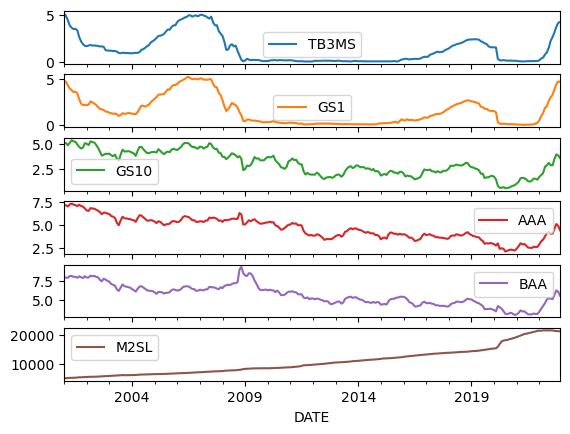

In [19]:
# график исходных данных
data.plot(subplots=True)

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>], dtype=object)

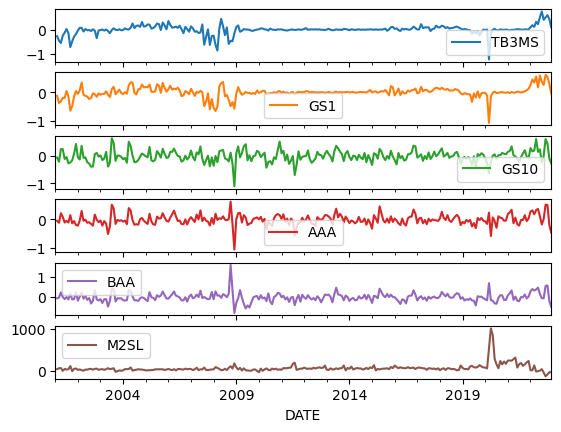

In [20]:
# график дифференцированных данных
data.diff().plot(subplots=True)

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>], dtype=object)

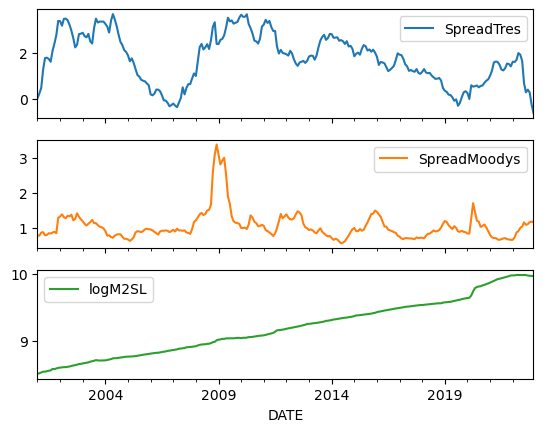

In [21]:
spreads = pd.DataFrame({'SpreadTres': data['GS10']-data['TB3MS'], 
                        'SpreadMoodys': data['BAA']-data['AAA'], 
                        'logM2SL': np.log(data['M2SL']) })
spreads.plot(subplots=True)

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>,
       <Axes: xlabel='DATE'>], dtype=object)

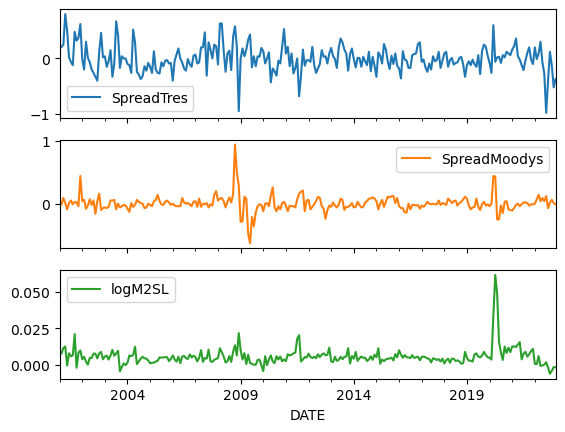

In [22]:
spreads.diff().plot(subplots=True)

## Модель

In [23]:
mod = smf.ols(formula='SpreadMoodys~SpreadTres+logM2SL', data=spreads.diff()).fit()
LM, LMpval, F, Fpval = sms.acorr_breusch_godfrey(mod, nlags=3)
LM, LMpval

(57.60099970871409, 1.9125351024585204e-12)

In [24]:
sms.durbin_watson(mod.resid)

1.1152055544921955

In [25]:
mod = smf.ols(formula='SpreadMoodys~SpreadTres+logM2SL', data=spreads.diff()).fit()
mod_hac = smf.ols(formula='SpreadMoodys~SpreadTres+logM2SL', data=spreads.diff()).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
summary_col(results=[mod, mod_hac], stars=True)

,SpreadMoodys I,SpreadMoodys II
Intercept,-0.0221**,-0.0221*
,(0.0102),(0.0131)
SpreadTres,-0.0082,-0.0082
,(0.0322),(0.0535)
logM2SL,4.2493***,4.2493**
,(1.2386),(1.7542)
R-squared,0.0433,0.0433
R-squared Adj.,0.0360,0.0360


In [26]:
mod.f_pvalue, mod_hac.f_pvalue

(0.0031491781652539137, 0.04998547417442565)